# Measuring and Reducing Dimensionality

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess
import warnings
warnings.filterwarnings('ignore')

We will use the sklearn [decomposition module](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) below:

In [64]:
from sklearn import decomposition

This is a module that includes matrix decomposition algorithms, including among others PCA, NMF or ICA. Most of the algorithms of this module can be regarded as dimensionality reduction techniques.

Helpers for Getting, Loading and Locating Data

In [65]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Get Data</span>

In [ ]:
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/line_data.csv')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/pong_data.hf5')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/cluster_3d_data.hf5')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/cosmo_targets.hf5')
wget_data('https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/data/spectra_data.hf5')

File ‘./tmp_data/line_data.csv’ already there; not retrieving.
File ‘./tmp_data/pong_data.hf5’ already there; not retrieving.
File ‘./tmp_data/cluster_3d_data.hf5’ already there; not retrieving.
File ‘./tmp_data/cosmo_targets.hf5’ already there; not retrieving.
File ‘./tmp_data/spectra_data.hf5’ already there; not retrieving.


## <span style="color:Orange">Load Data</span>

In [67]:
line_data     = pd.read_csv(locate_data('line_data.csv'))
pong_data     = pd.read_hdf(locate_data('pong_data.hf5'))
cluster_3d    = pd.read_hdf(locate_data('cluster_3d_data.hf5'))
cosmo_targets = pd.read_hdf(locate_data('cosmo_targets.hf5'))
spectra_data  = pd.read_hdf(locate_data('spectra_data.hf5'))

## <span style="color:Orange">Data Dimensionality</span>

We call the number of features (columns) in a dataset its "dimensionality". In order to learn how different features are related, we need enough samples to get a complete picture.

For example, imagine splitting each feature at its median value then, at a minimum, we would like to have at least one sample in each of the resulting $2^D$ bins (D = dimensionality = # of features = # of columns; $r^D$ is the volume of a D-dimensional hypercube with edge length $r$, with $r=2$ in our case). This is a very low bar and only requires 8 samples with $D=3$, but requires $2^{30} > 1$ billion samples with $D=30$.

To get a feel for how well sampled your dataset is, estimate how many bins you could split each feature (axis) into and end up with 1 sample per bin (assuming that features are uncorrelated). A value < 2 fails our minimal test above and anything < 5 is a potential red flag.

In [68]:
stats = []
for name in 'line_data', 'cluster_3d', 'cosmo_targets', 'pong_data', 'spectra_data':
    N, D = eval(name).shape
    stats.append([name, N, D, N ** (1 / D)])
pd.DataFrame(stats, columns=('Dataset', 'N', 'D', 'N**(1/D)')).round(3)

,Dataset,N,D,N**(1/D)
0,line_data,2000,3,12.599
1,cluster_3d,500,3,7.937
2,cosmo_targets,50000,6,6.070
3,pong_data,1000,20,1.413
4,spectra_data,200,500,1.011


However, not all features carry equal information and the effective dimensionality of a dataset might be lower than the number of columns.  As an extreme example, consider the following 2D data which is effectively 1D since one column has a constant value (zero):

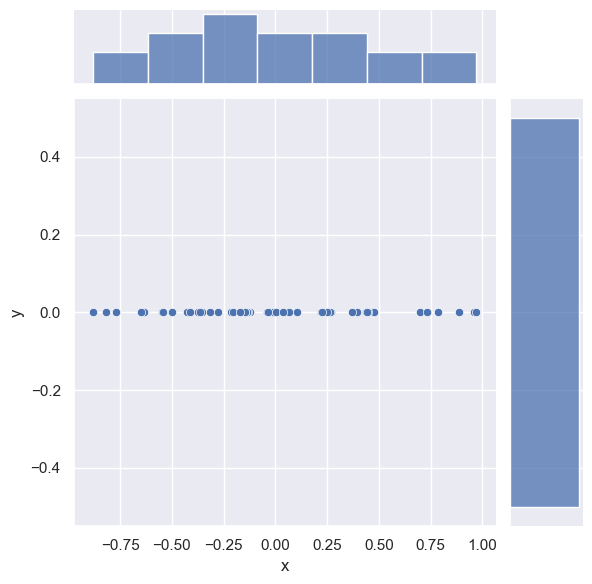

In [69]:
gen = np.random.RandomState(seed=123)
data = pd.DataFrame()
data['x'] = gen.uniform(-1, +1, 50)
data['y'] = np.zeros_like(data['x'])
sns.jointplot(data=data, x='x', y='y');

___<span style="color:violet">DISCUSS</span>___: Is this data is still 1D if (refer to the plots below):
 - we add some small scatter in the $2^\mathrm{nd}$ dimension?

 - we perform a coordinate rotation so that $y \sim m x$?

 - $y \sim f(x)$ where $f(x)$ is nonlinear?

The scatter adds new information in a second dimension, but we can approximately ignore it under two assumptions:
- The relative scaling of the $x$ and $y$ columns is meaningful (which is almost certainly not true if these columns have different dimensions - recall our earlier comments about normalizing data).

- The origin of the scatter is due to measurement error or some other un-informative process.

The rotation does not change the effective dimensionality of the data.

A non-linear relationship between $x$ and $y$ also does not change the underlying dimensionality since we could, in principle, perform a non-linear change of coordinates to undo it.  However, we can expect that non-linear relationships will be harder to deal with than linear ones.

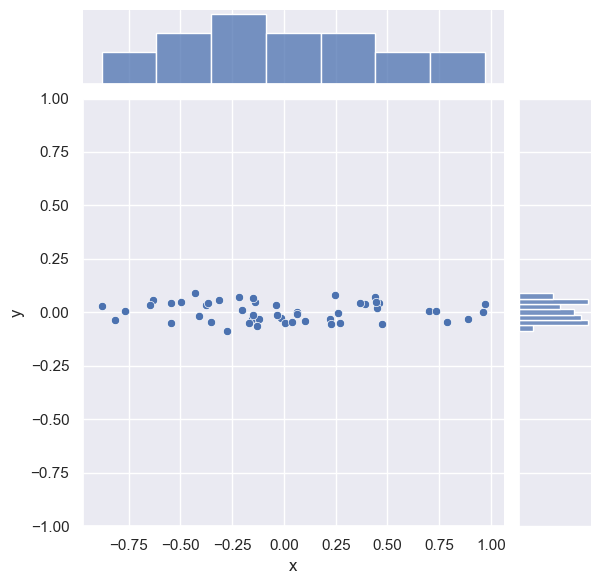

In [70]:
# Add some scatter in the 2nd dimension.
data['y'] = gen.normal(scale=0.04, size=len(data))
sns.jointplot(data=data, x='x', y='y');
plt.ylim(-1, +1);

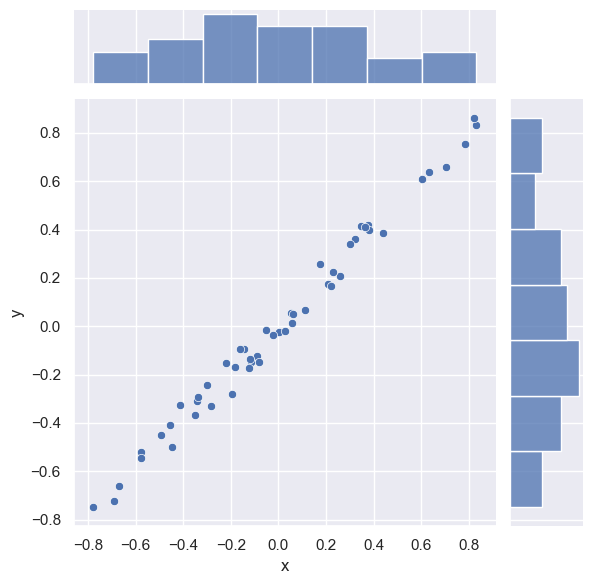

In [71]:
# Rotate by 30 deg counter-clockwise.
theta = np.deg2rad(30.)
rotated = data.copy()
rotated['x'] = np.cos(theta) * data['x'] - np.sin(theta) * data['y']
rotated['y'] = np.cos(theta) * data['x'] + np.sin(theta) * data['y']
#sns.jointplot('x', 'y', rotated, stat_func=None);
sns.jointplot(data=rotated, x='x', y='y');

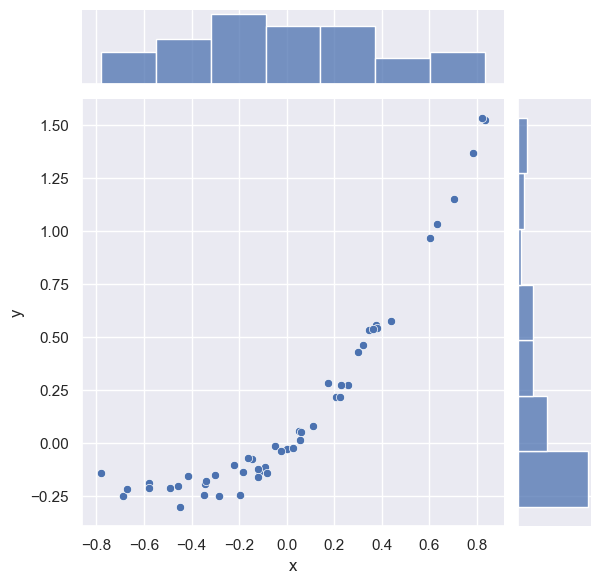

In [72]:
# Use the nonlinear y ~ x ** 2 + x instead of y ~ x.
nonlinear = rotated.copy()
nonlinear['y'] = rotated['y'] + rotated['x'] ** 2
sns.jointplot(data=nonlinear, x='x', y='y');

We will use `spectra_data` below.  Note from the table above that it appears to be severely undersampled with $N=200$, $D=500$.

___<span style="color:violet">EXERCISE</span>___: Plot some rows (samples) of `spectra_data` using `plt.plot(spectra_data.iloc[i], '.')` to get a feel for this dataset. What do you think the effective dimensionality of this data is?  (Hint: how many independent parameters you would need to generate this data?)

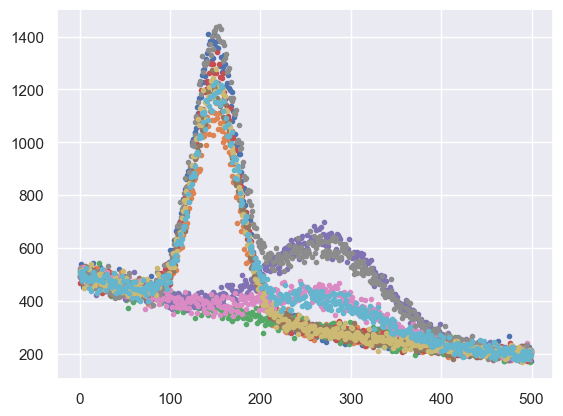

In [73]:
for i in range(10):
    plt.plot(spectra_data.iloc[i], '.')

Each sample is a graph of a smooth function with some noise added.  The smooth function has three distinct components: 
- two peaks, with fixed locations and shapes, and normalizations that vary independently.

- a smooth background with no free parameters.
Since the data could be reproduced with just normalization parameters (except for the noise), it has an effective dimensionality of $d=2$.

Note that the relative normalization of each feature is significant here, so we would not want to normalize this data and lose this information.  We refer to each sample as a "spectrum" since it looks similar to spectra obtained in different areas of physics (astronomy, nuclear physics, particle physics, ...)

## <span style="color:Orange">Linear Decompositions</span>

The goal of a linear decomposition is to automatically identify linear combinations of the original features that account for most of the variance in the data. Note that we are using variance (spread) as a proxy for "useful information", so it is essential that the relative normalization of our features is meaningful.

If we represent our data with the $N\times D$ matrix $X$, then a linear decomposition can be represented as the following matrix multiplication:

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/Dimensionality-LinearDecomposition.png" width=1000></img>
</div>

The $N\times d$ matrix $Y$ is a reduced representation of the original data $X$, with $d < D$ new features that are linear combinations of the original $D$ features.  We call the new features "latent variables", since they were already present in $X$ but only implicitly.

The $d\times D$ matrix $M$ specifies the relationship between the old and new features: each column is unit vector for a new feature in terms of the old features.  Note that $M$ is not square when $d < D$ and unit vectors are generally not mutually orthogonal (except for the PCA method).

A linear decomposition is not exact (hence the $\simeq$ above) and there is no "best" prescription for determining $Y$ and $M$. Below we review the most popular prescriptions implemented in the [sklearn.decomposition](http://scikit-learn.org/stable/modules/decomposition.html) module (links are to wikipedia and sklearn documentation):

| Method | sklearn |
| ------ | ------- |
| [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) | [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) |
| [Factor Analysis](https://en.wikipedia.org/wiki/Factor_analysis) | [FactorAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html) |
| [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) | [NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) |
| [Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis) | [FastICA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) |

All methods require that you specify the number of latent variables $d$ (but you can easily experiment with different values) and are called using (method = PCA, FactorAnalysis, NMF, FastICA):
```
fit = decomposition.method(n_components=d).fit(X)
```
The resulting decomposition into $Y$ and $M$ is given by:
```
M = fit.components_
Y = fit.transform(X)
```
except for FastICA, where &nbsp; `M = fit.mixing_.T`.

When $d < D$, we refer to the decomposition as a "dimensionality reduction". A useful visualization of how effectively the latent variables capture the interesting information in the original data is to reconstruct the original data using:
```
X' = Y M
```
and compare rows (samples) of $X'$ with the original $X$.  They will not agree exactly, but if the differences seem uninteresting (e.g., look like noise), then the dimensionality reduction was successful and you can use $Y$ instead of $X$ for subsequent analysis.

We will use the function below to demonstrate each of these in turn (but you can ignore its details unless you are interested):

In [74]:
def demo(method='PCA', d=2, data=spectra_data):
    
    X = data.values
    N, D = X.shape
    
    if method == 'NMF':
        # All data must be positive.
        assert np.all(X > 0)
        # Analysis includes the mean.
        mu = np.zeros(D)
        fit = eval('decomposition.' + method)(n_components=d, init='random').fit(X)
    else:
        mu = np.mean(X, axis=0)
        fit = eval('decomposition.' + method)(n_components=d).fit(X)
    
    # Check that decomposition has the expected shape.
    if method == 'FastICA':
        M = fit.mixing_.T
    else:
        M = fit.components_
    assert M.shape == (d, D)
    Y = fit.transform(X)
    assert Y.shape == (N, d)
    
    # Reconstruct X - mu from the fitted Y, M.
    Xr = np.dot(Y, M) + mu
    assert Xr.shape == X.shape
    
    # Plot pairs of latent vars.
    columns = ['y{}'.format(i) for i in range(d)]
    sns.pairplot(pd.DataFrame(Y, columns=columns))
    fig = plt.figure(figsize=(8.5, 4))
    plt.show()
    
    # Compare a few samples from X and Xr.
    fig = plt.figure(figsize=(8.5, 4))
    for i,c in zip((0, 6, 7), sns.color_palette()):
        plt.plot(X[i], '.', c=c, ms=5)
        plt.plot(Xr[i], '-', c=c)
    plt.xlim(-0.5, D+0.5)
    plt.xlabel('Feature #')
    plt.ylabel('Feature Value')
    if (data is spectra_data):
        label = '{}(d={}): $\sigma = {:.3f}$'.format(method, d, np.std(Xr - X))
    else:
        label = '{}(d={}): $\sigma = {:.1e}$'.format(method, d, np.std(Xr - X))
    plt.text(0.95, 0.9, label, horizontalalignment='right',
             fontsize='x-large', transform=plt.gca().transAxes)

### <span style="color:Lightgreen">Principal Component Analysis</span>

PCA is the most commonly used method for dimensionality reduction. The decomposition is uniquely specified by the following prescription (more details [here](https://en.wikipedia.org/wiki/Principal_component_analysis#Computing_PCA_using_the_covariance_method)):
- Find the eigenvectors and eigenvalues of the <span style="color:violet">sample covariance matrix</span> $C$

$$ \Large
C = \frac{1}{N-1}\, X^T X
$$

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; which is an [empirical estimate](https://en.wikipedia.org/wiki/Covariance#Calculating_the_sample_covariance) of the true covariance matrix using the data $X$ comprised of $N$ observations (samples) of $D$ features (i.e. $X$ is a $N \times D$ matrix)

- Construct $M$ from the eigenvectors of the sample covariance matrix $C$ ($X^T X$ up to a multiplicative constant) ordered by decreasing eigenvalue (which are all positive) and solve the resulting linear equations for the latent variables $Y$.
  
What you need to remember about eigenvectors and eigenvalues is that they always come in pairs, so that every eigenvector has an eigenvalue. Also, their number is equal to the number of dimensions of the data. For example, for a 3-dimensional data set, there are 3 variables, therefore there are 3 eigenvectors with 3 corresponding eigenvalues. The eigenvectors of the covariance matrix $C$ of the data are referred to as the ___principal axes___ of the data, and the projection of the data instances onto these principal axes are called the ___principal components___. The eigenvalues are simply the coefficients attached to the eigenvectors, which give the amount of variance carried in each principal axis. By ranking the eigenvectors in order of their eigenvalues, highest to lowest, you get the principal components in order of significance.

As with any matrix $C$, the eigenvectors $\vec{v}$ and eigenvalues $\lambda$ satisfy

$$ \Large
C\vec{v} = \lambda \vec{v}
$$

Next we put in an identity matrix $\tilde{1}$ so we are dealing with matrix-vs-matrix:

$$ \Large
C\vec{v} = \lambda \tilde{1} \vec{v}
$$

Bring all to left hand side:

$$ \Large
C\vec{v} - \lambda \tilde{1} \vec{v} = 0
$$

If $\vec{v}$ is non-zero then we can (hopefully) solve for $\lambda$ using just the ___determinant___:

$$ \Large
| C\vec{v} - \lambda \tilde{1} \vec{v} | = 0
$$
The rows of $M$ are the eigenvectors $\vec{v}$ and ordered by decreasing eigenvalues $\lambda$. 

At this point the decomposition is exact with $d = D$; and $Y$ and $M$ are $N \times D$ and $D \times D$ matrices, respectively. 

- Shrink $Y$ and $M$ from $D$ to $d$ rows ($M$) or columns ($Y$), which makes the decomposition approximate while discarding the least amount of variance in the original data (which we use as a proxy for "useful information").

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/Dimensionality-PCAdecomposition.png" width=1000></img>
</div>

The full $M$ matrix (before shrinking $D\rightarrow d$ &nbsp;) is orthogonal which means that

$$ \Large
M^T = M^{-1} ~~~~~~~~~~~~~~ \text{and} ~~~~~~~~~~~~~~ M M^T = \tilde{1}
$$

and satisfies

$$ \Large
X^T X = M^T \Lambda M
$$

where $\Lambda$ is a diagonal matrix of the decreasing eigenvalues (the variances $\sigma^2$). Note that this description glosses over some details that you will explore in your homework.

The resulting latent variables are *statistically uncorrelated* (which is a weaker statement than *statistically independent* -- see below), i.e., the [correlation coefficients](https://en.wikipedia.org/wiki/Correlation_coefficient) between different columns of $Y$ are approximately zero:

$$ \Large
\rho(j,k) = \frac{Y_j\cdot Y_k}{|Y_j|\,|Y_k|} \simeq 0 \; .
$$

The PCA demonstration below shows a pairplot of the latent variables from a $d=2$ decomposition, followed by a reconstruction of some samples (red curves) compared with the originals (red points).

Note that the reconstructed samples are in some sense *better* than the originals since the original noise was associated with a small eigenvalue that was trimmed!

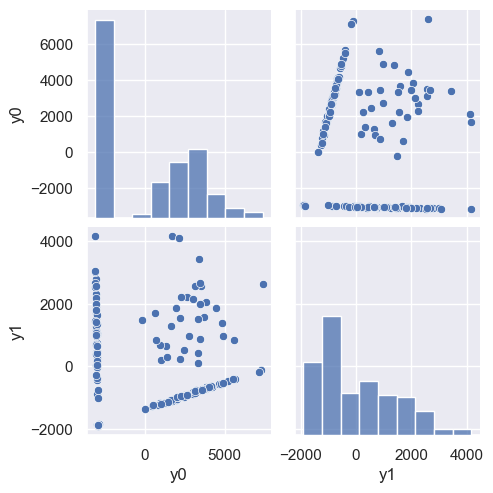

<Figure size 850x400 with 0 Axes>

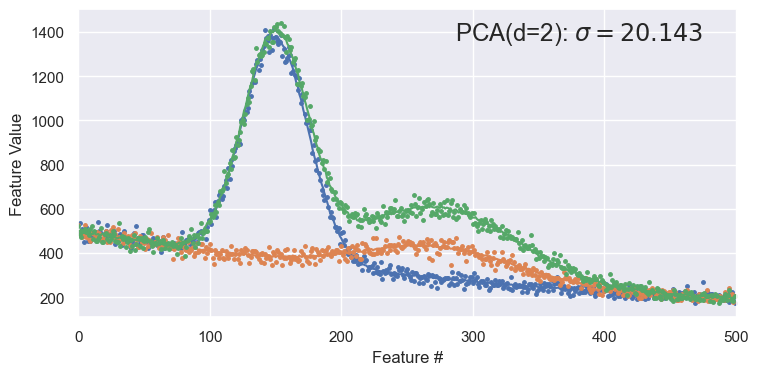

In [75]:
demo('PCA', d=2)

___<span style="color:violet">DISCUSS</span>___: How many clusters do you expect to see in the scatter plot of `y0` versus `y1` above based on what you know about this dataset?  Can you identify these clusters in plot above?

We expect to see 4 clusters, corresponding to spectra with:
- No peaks.

- Only the lower peak.

- Only the upper peak.

- Both peaks.

We already saw that this data can be generated from two flux values, giving the normalization of each peak. Lets assume that y0 and y1 are related to these fluxes to identify the clusters:
- Points near (-2000, -2000), with very little spread.

- Points along the horizontal line with `y0` ~ -2000.

- Points along the diagonal line.

- Points scattered between the two lines.

### <span style="color:Lightgreen">Factor Analysis</span>

Factor analysis (FA) often produces similar results to PCA, but is conceptually different.

Both PCA and FA implicitly assume that the data is approximately sampled from a multidimensional Gaussian. PCA then finds the principal axes of the the resulting multidimensional ellipsoid, while FA is based on a model for how the original data is generated from the latent variables.  Specifically, FA seeks latent variables that are uncorrelated unit Gaussians and allows for different noise levels in each feature, while assuming that this noise is uncorrelated with the latent variables.  PCA does not distinguish between "signal" and "noise" and implicitly assumes that the large eigenvalues are more signal-like and small ones more noise-like.

When the FA assumptions about the data (of Gaussian latent variables with uncorrelated noise added) are correct, it is certaintly the better choice, in principle.  In practice, FA decomposition is more expensive and requires an iterative Expectation-Maximization (EM) algorithm.  You should normally try both, but prefer the simpler PCA when the results are indistinguishable.

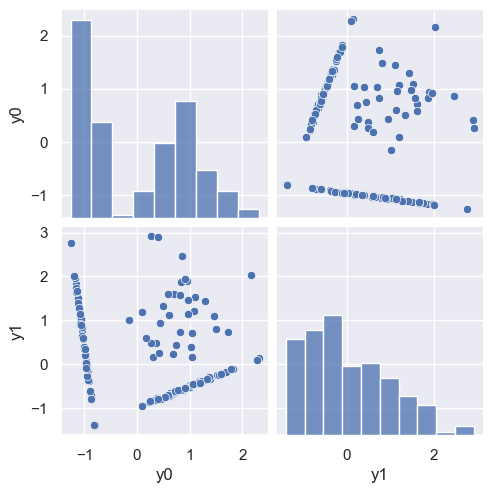

<Figure size 850x400 with 0 Axes>

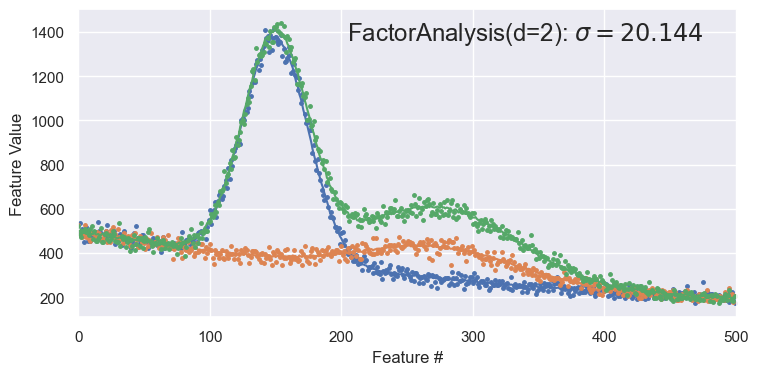

In [76]:
demo('FactorAnalysis', d=2)

### <span style="color:Lightgreen">Non-negative Matrix Factorization</span>

Most linear factorizations start by centering each feature about its mean over the samples:

$$ \Large
X_{ij} \rightarrow X_{ij} - \mu_i \quad , \quad \mu_i \equiv \frac{1}{N} \sum_i\, X_{ij} \; .
$$

As a result, latent variables are equally likely to be positive or negative.

Non-negative matrix factorization (NMF) assumes that the data are a (possibly noisy) linear superposition of different components, which is often a good description of data resulting from a physical process.  For example, the spectrum of a galaxy is a superposition of the spectra of its constituent stars, and the spectrum of a radioactive sample is a superposition of the decays of its constituent unstable isotopes.

These processes can only **add** data, so the elements of $Y$ and $M$ should all be $\ge 0$ if the latent variables describe additive mixtures of different processes.  The NMF factorization guarantees that both $Y$ and $M$ are positive, and requires that the input $X$ is also positive.  However, there is no guarantee that the non-negative latent variables found by NMF are due to physical mixtures.

Since NMF does not internally subtract out the means $\mu_i$, it generally needs an additional component to model the mean.  For `spectra_data` then, we should use d=3 for NMF to compare with PCA using d=2:

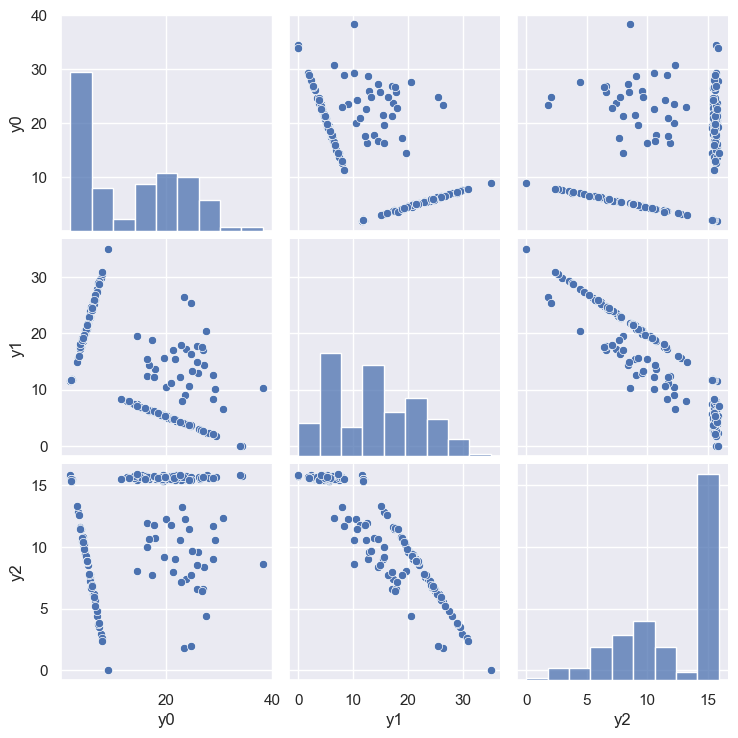

<Figure size 850x400 with 0 Axes>

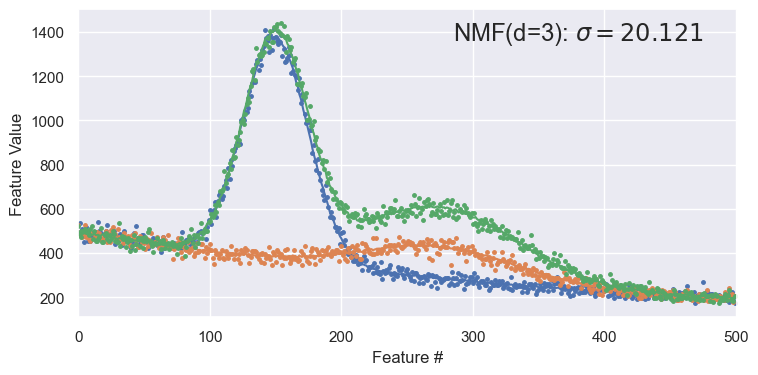

In [77]:
demo('NMF', d=3)

To see the importance of the extra latent variable, try with d=2 and note how poorly samples are reconstructed:

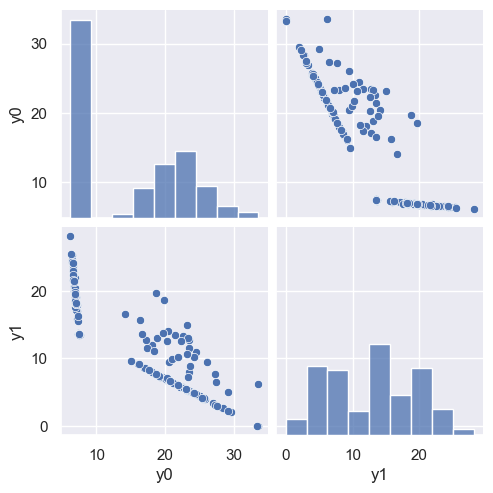

<Figure size 850x400 with 0 Axes>

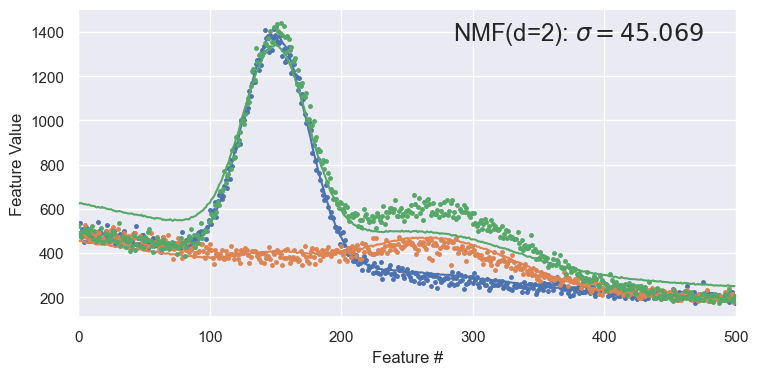

In [78]:
demo('NMF', d=2)

### <span style="color:Lightgreen">Independent Component Analysis</span>

The final linear decomposition we will consider is ICA, where the goal is to find latent variables $Y$ that are *statistically independent*, which is a stronger statement that the *statistically uncorrelated* guarantee of PCA. We will formalize the definition of independence soon but the basic idea is that the joint probability of a sample occuring with latent variables $y_1, y_2, y_3, \ldots$ can be factorized into independent probabilities for each component:

$$ \Large
P(y_1, y_2, y_3, \ldots) = P(y_1) P(y_2) P(y_3) \ldots
$$

ICA has some inherent ambiguities: both the ordering and scaling of latent variables is arbitrary, unlike with PCA. However, in practice, samples reconstructed with ICA often look similar to PCA and FA reconstructions.

ICA is also used for [blind signal separation](https://en.wikipedia.org/wiki/Blind_signal_separation) which is a common task is digital signal processing, where usually $d = N$.

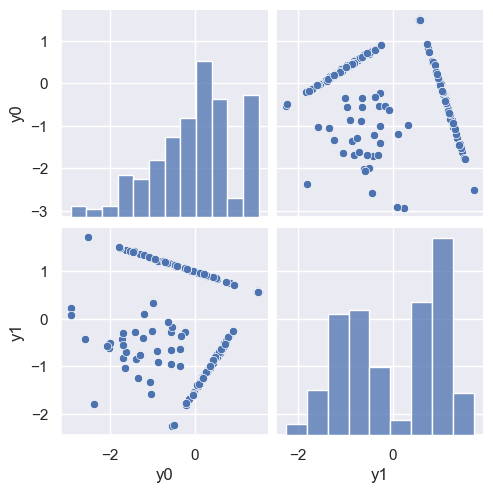

<Figure size 850x400 with 0 Axes>

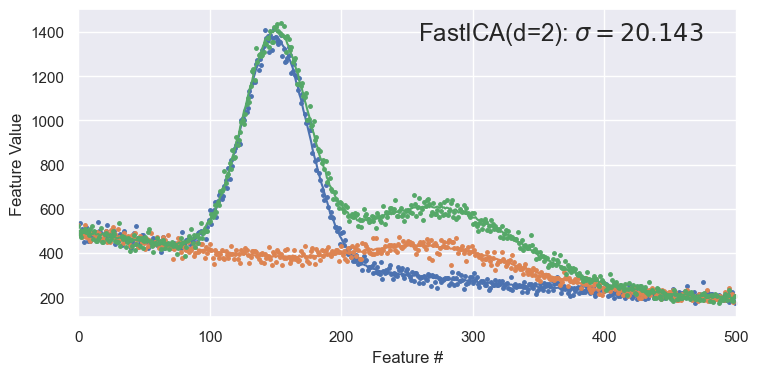

In [79]:
demo('FastICA', d=2)

### <span style="color:Lightgreen">Comparisons of Linear Methods</span>

To compare the four methods above, plot their normalized "unit vectors" (rows of the $M$ matrix). Note that only the NMF curves are always positive, as expected.  However, while all methods give excellent reconstructions of the original data, they also all mix the two peaks together.  In other words, none of the methods has discovered the natural latent variables of the underlying physical process: the individual peak normalizations.

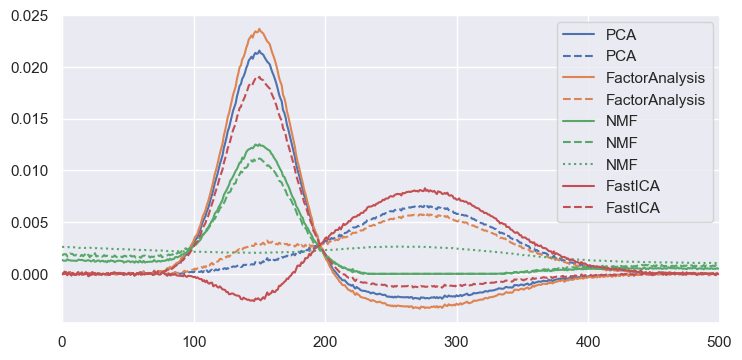

In [80]:
def compare_linear(data=spectra_data):
    X = data.values
    N, D = X.shape
    fig = plt.figure(figsize=(8.5, 4))
    for j, method in enumerate(('PCA', 'FactorAnalysis', 'NMF', 'FastICA')):
        if method == 'NMF':
            d = 3
            mu = np.zeros(D)
        else:
            d = 2
            mu = np.mean(X, axis=0)
        fit = eval('decomposition.' + method)(n_components=d).fit(X - mu)
        M = fit.mixing_.T if method == 'FastICA' else fit.components_
        for i in range(d):
            unitvec = M[i] / M[i].sum()
            plt.plot(unitvec, label=method, c=sns.color_palette()[j], ls=('-', '--', ':')[i])
    plt.legend()
    plt.xlim(-0.5, D + 0.5)
    
compare_linear()

___<span style="color:violet">EXERCISE</span>___ Use the `demo()` function with `data=pong_data` and $d = 1, 2, 3,\ldots$ to determine how many latent variables are necessary to give a good reconstruction.  Do the 1D plots of individual `pong_data` samples make sense?

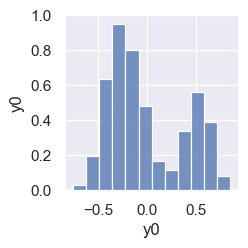

<Figure size 850x400 with 0 Axes>

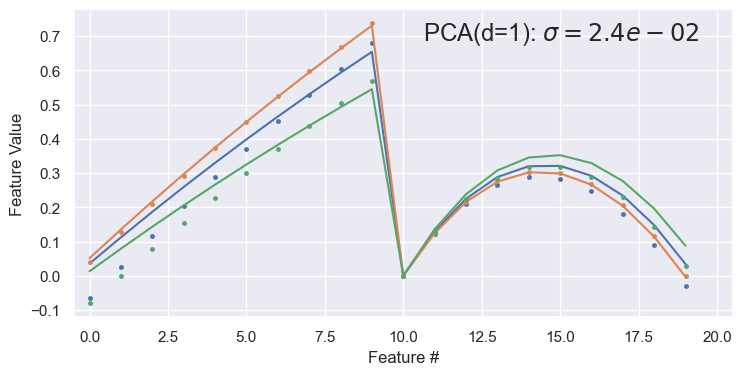

In [81]:
demo('PCA', d=1, data=pong_data)

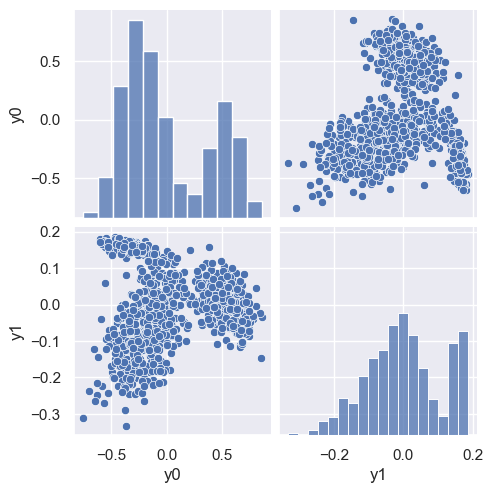

<Figure size 850x400 with 0 Axes>

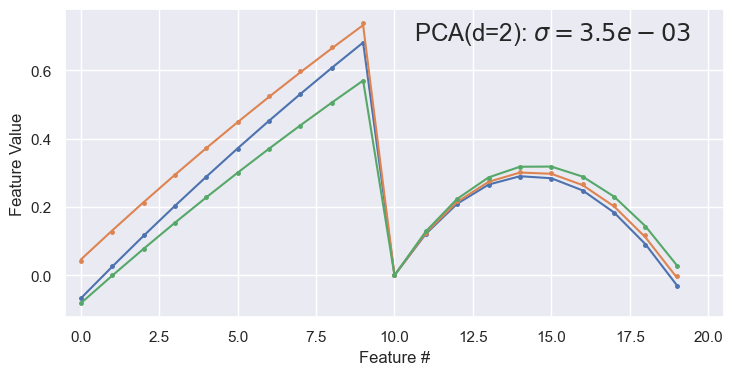

In [82]:
demo('PCA', d=2, data=pong_data)

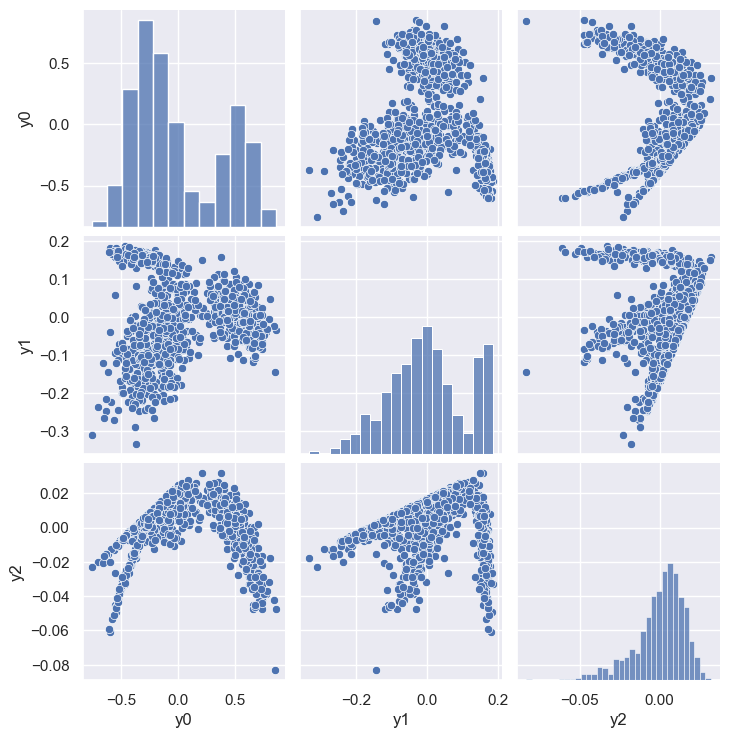

<Figure size 850x400 with 0 Axes>

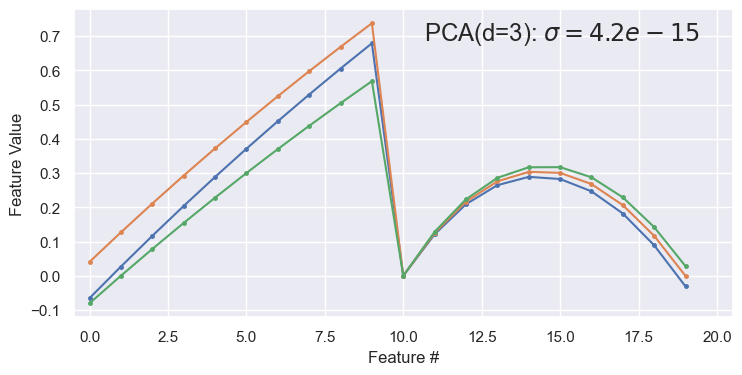

In [83]:
demo('PCA', d=3, data=pong_data)

Two latent variables ($d=2$) are sufficient for a good reconstruction. The abrupt transition at feature 10 in the reconstructed samples is because features 0-9 are ~linearly increasing x values, while features 10-19 are the corresponding ~parabolic y values.  Note that this dataset has negligible noise compared with `spectra_data`.

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025